# Data Training, Regularizing, Feature Selection, and Testing

## Packages needed for analysis:

In [118]:
import pandas as pd
import numpy as np
import os
import datetime

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# BL: These are just helpful as I debug things
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

Import cleaned data on a Fips-date level

In [113]:
df = pd.read_csv("../Data/merged.csv", parse_dates=["date"], dtype={'fips': str})
df.head()
#df['DATE']= pd.to_datetime(df['date'])
#df["Date"] = df["DATE"].dt.date

,state,fips,county,date,cumulative_cases,cumulative_deaths,new_cases,new_deaths,new_cases_7avg,new_deaths_7avg,2weeksago_cases_7avg,2weeksago_deaths_7avg,total_pop,male,perc_male,female,perc_female,age_15_19,p_age_15_19,age_20_24,p_age_20_24,age_25_34,p_age_25_34,age_35_44,p_age_35_44,age_45_54,p_age_45_54,age_55_59,p_age_55_59,age_60_64,p_age_60_64,age_median,age_62over,p_age_62over,age_65over,p_age_65over,white,p_white,black,p_black,native,p_native,asian,p_asian,hawaiian,p_hawaiian,other_race,p_other_race,hispanic,p_hispanic,housing_units,below_50_pov,below_125_pov,below_150_pov,below_185_pov,below_200_pov,below_300_pov,below_400_pov,below_500_pov,below_pov,male_below_pov,female_below_pov,age_under14,p_under14,non_white,p_non_white,total_adult_hospitalizations,total_pediatric_hospitalizations,prev_day_adult_admit_7daysum,prev_day_adult_admit_18-19_7daysum,prev_day_adult_admit_20-29_7daysum,prev_day_adult_admit_30-39_7daysum,prev_day_adult_admit_40-49_7daysum,prev_day_adult_admit_50-59_7daysum,prev_day_adult_admit_60-69_7daysum,prev_day_adult_admit_70-79_7daysum,prev_day_adult_admit_80+_7daysum,prev_day_adult_admit_unknown_7daysum,mask_mandate,retail_rec,grocery_pharm,parks,transit,workplace,residential,new doses,cumulative doses
0,IL,17001,Adams,2020-03-20,1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,66085,32276,48.8,33809,51.2,3679,5.6,3684,5.6,8060,12.2,7657,11.6,8105,12.3,4866,7.4,4251,6.4,41.5,15621,23.6,13186,20.0,61406,92.9,2731,4.1,297,0.4,527,0.8,14,0.0,113,0.2,1059,1.6,30192,3447,10417,13344,17583,19205,33041,43233,50182,8031,3605,4426,406544754057,6.26.86.1,4679,7.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-33.0,11.0,NaN,-7.0,-22.0,13.0,0.0,0.0
1,IL,17001,Adams,2020-03-21,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66085,32276,48.8,33809,51.2,3679,5.6,3684,5.6,8060,12.2,7657,11.6,8105,12.3,4866,7.4,4251,6.4,41.5,15621,23.6,13186,20.0,61406,92.9,2731,4.1,297,0.4,527,0.8,14,0.0,113,0.2,1059,1.6,30192,3447,10417,13344,17583,19205,33041,43233,50182,8031,3605,4426,406544754057,6.26.86.1,4679,7.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-55.0,-14.0,NaN,-30.0,-15.0,NaN,0.0,0.0
2,IL,17001,Adams,2020-03-22,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66085,32276,48.8,33809,51.2,3679,5.6,3684,5.6,8060,12.2,7657,11.6,8105,12.3,4866,7.4,4251,6.4,41.5,15621,23.6,13186,20.0,61406,92.9,2731,4.1,297,0.4,527,0.8,14,0.0,113,0.2,1059,1.6,30192,3447,10417,13344,17583,19205,33041,43233,50182,8031,3605,4426,406544754057,6.26.86.1,4679,7.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-63.0,-42.0,NaN,NaN,-25.0,NaN,0.0,0.0
3,IL,17001,Adams,2020-03-23,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66085,32276,48.8,33809,51.2,3679,5.6,3684,5.6,8060,12.2,7657,11.6,8105,12.3,4866,7.4,4251,6.4,41.5,15621,23.6,13186,20.0,61406,92.9,2731,4.1,297,0.4,527,0.8,14,0.0,113,0.2,1059,1.6,30192,3447,10417,13344,17583,19205,33041,43233,50182,8031,3605,4426,406544754057,6.26.86.1,4679,7.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-49.0,-20.0,NaN,-21.0,-29.0,14.0,0.0,0.0
4,IL,17001,Adams,2020-03-24,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66085,32276,48.8,33809,51.2,3679,5.6,3684,5.6,8060,12.2,7657,11.6,8105,12.3,4866,7.4,4251,6.4,41.5,15621,23.6,13186,20.0,61406,92.9,2731,4.1,297,0.4,527,0.8,14,0.0,113,0.2,1059,1.6,30192,3447,10417,13344,17583,19205,33041,43233,50182,8031,3605,4426,406544754057,6.26.86.1,4679,7.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-46.0,-20.0,NaN,NaN,-31.0,15.0,0.0,0.0


In [111]:
df.dtypes

state                                           object
fips                                            object
county                                          object
date                                    datetime64[ns]
cumulative_cases                                 int64
cumulative_deaths                              float64
new_cases                                      float64
new_deaths                                     float64
new_cases_7avg                                 float64
new_deaths_7avg                                float64
2weeksago_cases_7avg                           float64
2weeksago_deaths_7avg                          float64
total_pop                                        int64
male                                             int64
perc_male                                      float64
female                                           int64
perc_female                                    float64
age_15_19                                        int64
p_age_15_1

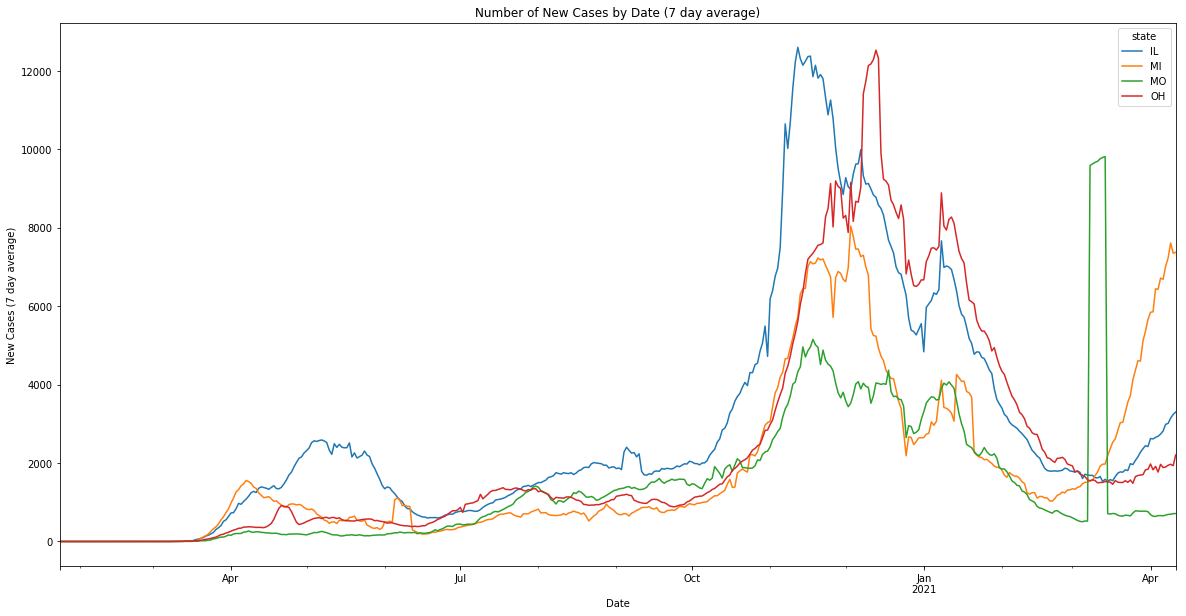

In [114]:
new_cases_state = df.groupby(["date","state"])["new_cases_7avg"].sum().unstack()
new_cases_state = new_cases_state.fillna(0)
new_cases_state
new_cases_state.plot(figsize=(20,10))
plt.title("Number of New Cases by Date (7 day average)")
plt.ylabel("New Cases (7 day average)")
plt.xlabel("Date")
plt.show()

Based on the above chart, clearly there is something wrong with March 8 for Missouri. According to research, they dumped probable cases into the system that day. Therefore, we will replace with the average of the previous 7 days.
This is also the case with Ohio December 8.

**Question: Do we need to adjust the 7 day average count with this information?**

BL: replotted above with the 7 day average variable that's already in the dataset, but seems like there's still a huge jump at those dates.  Maybe we can impute and add those cases proportionally to the prior dates? 

In [109]:
# from datetime import date
# df.dtypes
# # Since the data is on FIPS level, not sure best way to do this? 
# df["rolling_mean"] = df["new_cases"].rolling(7).mean().shift(1)

# #Missouri
# mask1 = (df['Date'] == date(2021, 3, 8)) & (df.state == "MO")
# #Ohio
# mask2 = (df['Date'] == date(2020, 12, 8)) & (df.state == "OH")

# df.loc[mask1, 'new_cases'] = df["rolling_mean"]
# df.loc[mask2, 'new_cases'] = df["rolling_mean"]
# df

In [55]:
#If using sklearn - How do we account for keeping Fips together? I dont think this can:
# Here are some alternatives: https://stackoverflow.com/questions/51963713/cross-validation-for-grouped-time-series-panel-data

tss = TimeSeriesSplit(n_splits = 3)
# Probably will want to take more variables out
X = df.drop(labels=['new_cases'], axis=1)
y = df['new_cases']
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


Feature Selection Sources:
    https://towardsdatascience.com/the-art-of-finding-the-best-features-for-machine-learning-a9074e2ca60d
    https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e
Need to use a model to check which features? I would say Linear for simplicity but not sure that really works with this? So maybe logistic to start and check features and then we can compare other models? Not sure

BL: Not sure how we can use logistic since logistic is only used to predict a binary variable, right?

In [105]:
# This normalize function is from Roberto's team from last year but I like how it reads in both training
# and testing at once. I think this makes a lot of sense especially if we use the Time-Based Cross Validation
# to create the training and testing where everything will need to be looped. 
# SO maybe put this into your pipeline file

def normalize(train_data, test_data, features):
    '''
    takes 2 datasets (testing data and trainning data) and a list of features to normalize 
    and changes columns to normalized new columns.
    '''
    
    scaler = StandardScaler()
    train = train_data.copy()
    test = test_data.copy()
    
    normal_train = scaler.fit_transform(train[features])
    normal_test = scaler.transform(test[features])
    
    for i, col in enumerate(features):
        train.loc[:, col] = normal_train[:, i]
        test.loc[:, col] = normal_test[:, i]

    return train, test


# BL: my one hot encoder function from the last assignment
def one_hot_encode(df, var_list):
    """
    Helper function for standardize_encoding
    """
    for var in var_list:
        dummies = pd.get_dummies(df[var], prefix=var)
        df = pd.concat([df.reset_index(drop=True), dummies], axis=1)

    return df.drop(columns=var_list)


In [5]:
# From: https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8
import timesplit as ts

In [119]:
# one hot encode, 
df_encoded = one_hot_encode(df, ["state", "fips"])

# drop all rows with any na's just to get a model through
df_encoded = df_encoded.dropna()


tscv = ts.TimeBasedCV(train_period=21,
                      test_period=7,
                      freq='days')

# split df into features and labels
X = df_encoded.drop(columns=["cumulative_cases", "cumulative_deaths",
                     "new_cases", "new_deaths",
                     "new_cases_7avg", "new_deaths_7avg", "county",
                     "age_under14", "p_under14"])

y = df_encoded["new_cases_7avg"]

# get list of numerical features
numerical_features = X.columns.tolist()[4:]
numerical_features.remove('mask_mandate')
numerical_features

# create list for scores
r2s = []
mses = []

# grabbed most of this from the towards data science article
for train_index, test_index in tscv.split(X, date_column='date'):

    data_train   = X.loc[train_index].drop('date', axis=1)
    target_train = y.loc[train_index]

    data_test    = X.loc[test_index].drop('date', axis=1)
    target_test  = y.loc[test_index]

    # if needed, do preprocessing here
    
    # normalize numerical features
    data_train, data_test = normalize(data_train, data_test, numerical_features)

    clf = LinearRegression()
    clf.fit(data_train,target_train)

    preds = clf.predict(data_test)

    # accuracy for the current fold only    
    r2score = clf.score(data_test,target_test)
    r2s.append(r2score)
    
    mse = mean_squared_error(target_test, preds, squared=True)
    mses.append(mse)

In [120]:
# average r2 on each fold (on our heavily subsetted data)
average_r2score = np.mean(r2s)
average_r2score

0.6950215773970609

In [121]:
# average mse on each fold (on our heavily subsetted data)
average_mse = np.mean(mses)
average_mse

11995.795880717573

Data issues we're going to have to fix:
- variables like p_age...over have -1's
- under 14 variables (like "p_under14" and "age_under14") have weird values that seem either too high or have too many decimal points
- We're going to have to deal with the missingness in our dataset because linear regression can't have missing values
    - missingness in hospitals data
    - missingness in mobility data (some columns have NaN's sprinkled throughout so can we fill in those NaN's by interpolating?)
    - some missingness in mask data but I think we can update data to make it slightly better

In [122]:
hospitals.head()

,date,state,fips,total_adult_hospitalizations,total_pediatric_hospitalizations,prev_day_adult_admit_7daysum,prev_day_adult_admit_18-19_7daysum,prev_day_adult_admit_20-29_7daysum,prev_day_adult_admit_30-39_7daysum,prev_day_adult_admit_40-49_7daysum,prev_day_adult_admit_50-59_7daysum,prev_day_adult_admit_60-69_7daysum,prev_day_adult_admit_70-79_7daysum,prev_day_adult_admit_80+_7daysum,prev_day_adult_admit_unknown_7daysum
0,2020-07-31,IL,17001,73.0,0.0,15.0,0.0,3.0,0.0,3.0,3.0,3.0,7.0,3.0,0.0
1,2020-08-01,IL,17001,73.0,0.0,15.0,0.0,3.0,0.0,3.0,3.0,3.0,7.0,3.0,0.0
2,2020-08-02,IL,17001,73.0,0.0,15.0,0.0,3.0,0.0,3.0,3.0,3.0,7.0,3.0,0.0
3,2020-08-03,IL,17001,73.0,0.0,15.0,0.0,3.0,0.0,3.0,3.0,3.0,7.0,3.0,0.0
4,2020-08-04,IL,17001,73.0,0.0,15.0,0.0,3.0,0.0,3.0,3.0,3.0,7.0,3.0,0.0


In [129]:
mobility["date"].min()

Timestamp('2020-02-15 00:00:00')

In [130]:

df.isnull().sum()

state                                        0
fips                                         0
county                                       0
date                                         0
cumulative_cases                             0
cumulative_deaths                            0
new_cases                                    0
new_deaths                                   0
new_cases_7avg                               0
new_deaths_7avg                              0
2weeksago_cases_7avg                         0
2weeksago_deaths_7avg                        0
total_pop                                    0
male                                         0
perc_male                                    0
female                                       0
perc_female                                  0
age_15_19                                    0
p_age_15_19                                  0
age_20_24                                    0
p_age_20_24                                  0
age_25_34    

In [131]:
masks["date"].max()

Timestamp('2021-03-22 00:00:00')

In [132]:
df["new_cases_7avg"].min()

-39.0